# PDE-FIND for identifying Navier-Stokes

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND for the vorticity equation given a simulation of fluid flowing around a cylinder.
\begin{align*}
\omega_t &= \frac{1}{Re}\nabla^2 \omega - (V \cdot \nabla)\omega\\
V &= (v,u)\\
Re &= 100
\end{align*}
The x and y components of the velocity field are given as forcing terms to the PDE.  That is, they appear in $\Theta$, but are not differentiated.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pde_diff_new
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from abess.linear import LinearRegression
import pysindy as ps
from solvel0 import solvel0
from findiff import FinDiff

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "./"

from misc import h5file

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


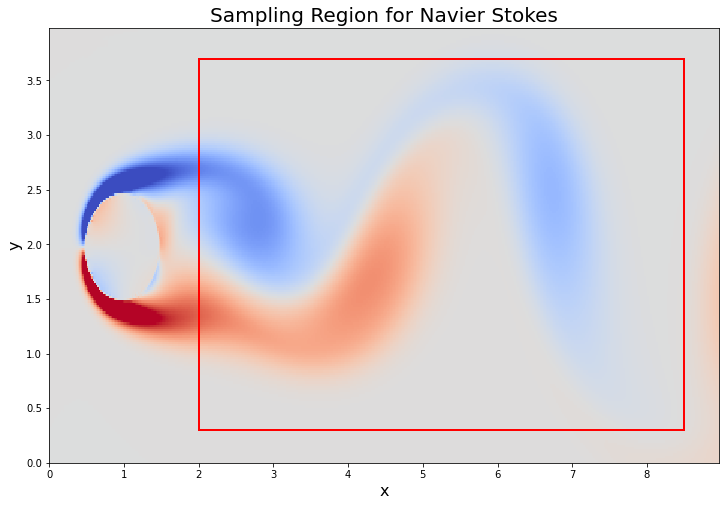

In [2]:
# Load data
steps = 151
n = 449
m = 199
U = np.load('../Datasets/course_timestep_cylinder/Cylinder_U.npy')
V = np.load('../Datasets/course_timestep_cylinder/Cylinder_V.npy')
W = np.load('../Datasets/course_timestep_cylinder/Cylinder_W.npy')

dt = 0.2
dx = 0.02
dy = 0.02

x = np.arange(n)*dx
y = np.arange(m)*dy
t = np.arange(steps)*dt

# plot the data
xx, yy = meshgrid(x, y)
pcolor(xx,yy,W[:,:,75].T,cmap='coolwarm', vmin=-4, vmax=4, shading='auto')

# Cut out the portion of the data before the cylinder
xmin = 100*dx
xmax = 425*dx
ymin = 15*dy
ymax = 185*dy
plot([xmin,xmin],[ymin,ymax],'r',linewidth = 2)
plot([xmax,xmax],[ymin,ymax],'r',linewidth = 2)
plot([xmin,xmax],[ymin,ymin],'r',linewidth = 2)
plot([xmin,xmax],[ymax,ymax],'r',linewidth = 2)
xlim([0,n*dx-dx])
ylim([0,m*dy])
title('Sampling Region for Navier Stokes', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)

xmin = 100
xmax = 425
ymin = 15
ymax = 185
x = x[xmin:xmax]
y = y[ymin:ymax]
W = W[xmin:xmax,ymin:ymax,:]
U = U[xmin:xmax,ymin:ymax,:]
V = V[xmin:xmax,ymin:ymax,:]
n,m,steps = W.shape

# Add in noise with magnitude equal to 1% of std dev of data
noise_lv = 1
numpy.random.seed(0)
W = W + noise_lv*0.01*np.std(W)*np.random.randn(n,m,steps)
U = U + noise_lv*0.01*np.std(U)*np.random.randn(n,m,steps)
V = V + noise_lv*0.01*np.std(V)*np.random.randn(n,m,steps)

In [3]:
import sgolay2
wn = W.T
un = U.T
vn = V.T

div = 30
ws = max(un[0].shape)//div; po = 2
if ws%2 == 0: ws -=1
    
wnd = []
for i in trange(wn.shape[0]):
    wnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(wn[i]))
W = np.stack(wnd, axis=0).T
    
und = []
for i in trange(un.shape[0]):
    und.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[i]))
U = np.stack(und, axis=0).T

vnd = []
for i in trange(vn.shape[0]):
    vnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[i]))
V = np.stack(vnd, axis=0).T

del und, vnd, un, vn

100%|█████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:01<00:00, 99.96it/s]


In [4]:
# Sample a collection of data points, stay away from edges so I can just use centered finite differences.
# num_xy = 5000
# num_t = 60
# num_points = num_xy * num_t
# boundary = 5
# boundary_x = 10
# points = {}
# count = 0

# for p in range(num_xy):
#     x = np.random.choice(np.arange(boundary_x,n-boundary_x),1)[0]
#     y = np.random.choice(np.arange(boundary,m-boundary),1)[0]
#     for t in range(num_t):
#         points[count] = [x,y,2*t+12]
#         count = count + 1
        
# x_axis = set()
# y_axis = set()
# t_axis = set()
# for p in points:
#     x, y, t = points[p]
#     x_axis.add(x)
#     y_axis.add(y)
#     t_axis.add(t)
    
# x_axis = np.array(sorted(x_axis))
# y_axis = np.array(sorted(y_axis))
# t_axis = np.array(sorted(t_axis))

# W = W[x_axis, :, :][:, y_axis, :][:, :, t_axis]
# U = U[x_axis, :, :][:, y_axis, :][:, :, t_axis]
# V = V[x_axis, :, :][:, y_axis, :][:, :, t_axis]

In [5]:
Wn = W.reshape(n*m,steps)
Un = U.reshape(n*m,steps)
Vn = V.reshape(n*m,steps)
uwn,sigmawn,vwn = np.linalg.svd(Wn, full_matrices=False); vwn = vwn.T
uun,sigmaun,vun = np.linalg.svd(Un, full_matrices=False); vun = vun.T
uvn,sigmavn,vvn = np.linalg.svd(Vn, full_matrices=False); vvn = vvn.T
dim_w = 26
dim_u = 20
dim_v = 20
W = uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)).reshape(n,m,steps)
U = uun[:,0:dim_u].dot(np.diag(sigmaun[0:dim_u]).dot(vun[:,0:dim_u].T)).reshape(n,m,steps)
V = uvn[:,0:dim_v].dot(np.diag(sigmavn[0:dim_v]).dot(vvn[:,0:dim_v].T)).reshape(n,m,steps)
del Wn, Un, Vn

In [6]:
# Wn = W.reshape(n*m,steps)
# Un = U.reshape(n*m,steps)
# Vn = V.reshape(n*m,steps)
# pca = PCA(n_components=26, whiten=False)
# Wn = pca.fit_transform(Wn)
# W = pca.inverse_transform(Wn).reshape(n,m,steps)
# pca = PCA(n_components=20, whiten=False)
# Un = pca.fit_transform(Un)
# U = pca.inverse_transform(Un).reshape(n,m,steps)
# pca = PCA(n_components=20, whiten=False)
# Vn = pca.fit_transform(Vn)
# V = pca.inverse_transform(Vn).reshape(n,m,steps)
# del Wn, Un, Vn

In [7]:
def build(*args): return np.stack([a.ravel() for a in args], axis=-1)

acc=4
d_dx = FinDiff(0, dx, 1, acc=acc)
d_dxx = FinDiff(0, dx, 2, acc=acc)
d_dy = FinDiff(1, dy, 1, acc=acc)
d_dyy = FinDiff(1, dy, 2, acc=acc)
d_dt = FinDiff(2, dt, 1, acc=acc)

W_x, W_y, W_xx, W_yy = d_dx(W), d_dy(W), d_dxx(W), d_dyy(W)

In [8]:
data_names = ['w', 'u', 'v']
diff_names = ['w_{x}', 'w_{y}', 'w_{xx}', 'w_{yy}']
inter_names = data_names + diff_names
inter = []
for i, data in enumerate([W, U, V]):
    for j, diff in enumerate([W_x, W_y, W_xx, W_yy]):
        inter.append(data*diff)
        inter_names.append(data_names[i]+diff_names[j])
inter_names

['w',
 'u',
 'v',
 'w_{x}',
 'w_{y}',
 'w_{xx}',
 'w_{yy}',
 'ww_{x}',
 'ww_{y}',
 'ww_{xx}',
 'ww_{yy}',
 'uw_{x}',
 'uw_{y}',
 'uw_{xx}',
 'uw_{yy}',
 'vw_{x}',
 'vw_{y}',
 'vw_{xx}',
 'vw_{yy}']

In [9]:
X_pre = build(W, U, V, d_dx(W), d_dy(W), d_dxx(W), d_dyy(W), *inter)
y_pre = d_dt(W).ravel().reshape(-1, 1)

In [10]:
# w/ denoise
# [(3,),
#  (11, 16),
#  (6, 11, 16),
#  (5, 6, 11, 16),
#  (0, 5, 6, 11, 16),
#  (0, 2, 5, 6, 11, 16),
#  (0, 2, 5, 6, 11, 14, 16),
#  (0, 2, 3, 5, 6, 11, 14, 16),
#  (0, 2, 3, 5, 6, 11, 13, 14, 16),
#  (0, 2, 3, 5, 6, 8, 11, 13, 14, 16)]

grb_solve = solvel0(X_pre, y_pre, is_normal=False, max_complexity=1+X_pre.shape[-1]//2)
grb_solve

  0%|                                                                                                | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.33s/it]


[(3,),
 (11, 16),
 (6, 11, 16),
 (5, 6, 11, 16),
 (0, 5, 6, 11, 16),
 (0, 2, 5, 6, 11, 16),
 (0, 2, 5, 6, 11, 14, 16),
 (0, 2, 3, 5, 6, 11, 14, 16),
 (0, 2, 3, 5, 6, 11, 13, 14, 16),
 (0, 2, 3, 5, 6, 8, 11, 13, 14, 16)]

In [11]:
for e in grb_solve[3]:
    print(inter_names[e])

w_{xx}
w_{yy}
uw_{x}
vw_{y}


In [12]:
# Brute for clean all == grb_solve
# best_subsets = [(3,), 
#                 (11, 16), 
#                 (6, 11, 16), 
#                 (5, 6, 11, 16), 
#                 (2, 5, 6, 11, 16), 
#                 (2, 5, 6, 11, 13, 16), 
#                 (0, 2, 5, 6, 11, 13, 16), 
#                 (0, 2, 5, 6, 11, 13, 15, 16), 
#                 (0, 1, 2, 5, 6, 11, 13, 15, 16), 
#                 (0, 1, 2, 3, 5, 6, 11, 13, 15, 16)]

# Brute for 1%noise == grb_solve
# best_subsets = [(3,),
#                 (11, 16),
#                 (6, 11, 16),
#                 (5, 6, 11, 16),
#                 (0, 5, 6, 11, 16),
#                 (0, 2, 5, 6, 11, 16),
#                 (0, 2, 5, 6, 11, 14, 16),
#                 (0, 2, 3, 5, 6, 11, 14, 16),
#                 (0, 2, 3, 5, 6, 11, 13, 14, 16),
#                 (0, 2, 3, 5, 6, 8, 11, 13, 14, 16)]

ever = reduce(np.union1d, grb_solve)
# _, bs = brute_force_all_subsets(X_pre[:, ever], y_pre, max_support_size=len(grb_solve))
# best_subsets = [tuple(ever[list(b)]) for b in bs]

best_subsets = [(3,),
                (11, 16),
                (6, 11, 16),
                (5, 6, 11, 16),
                (0, 5, 6, 11, 16),
                (0, 2, 5, 6, 11, 16),
                (0, 2, 5, 6, 11, 14, 16),
                (0, 2, 3, 5, 6, 11, 14, 16),
                (0, 2, 3, 5, 6, 11, 13, 14, 16),
                (0, 2, 3, 5, 6, 8, 11, 13, 14, 16)]

In [13]:
for e1, e2 in zip(grb_solve, best_subsets): 
    if e1 != e2: print(e1, e2)

In [14]:
from UBIC import UBIC, UBICs, baye_uncertainties, log_like_value, decreasing_values_indices

In [18]:
tau = 3
scale = 1
scale = np.log(len(y_pre))
pers = np.arange(50+5, 100+5, 5, dtype=np.int32)
success_counts = 0
all_counts = 0

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
print(min(b_bics)-max(b_bics))

predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*len(efi)
    lower_bounds.append(lower_bound)

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])

for per in pers:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
    # print(thres)

    last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
    # print("max_lam:", last_lam)
    delta = last_lam/tau
    now_lam = last_lam-delta
    last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
    last_bc = np.argmin(last_ubic)
    while now_lam > 0:
        now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
        now_bc = np.argmin(now_ubic)

        diff_com = now_bc-last_bc
        diff_bic = b_bics[now_bc]-b_bics[last_bc]
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
        # print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), imp)

        if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
            (diff_com < 0 and diff_bic > 0 and imp > thres):
            break

        last_lam = now_lam
        now_lam = last_lam-delta
        last_ubic = now_ubic
        last_bc = now_bc

    best_bc = last_bc
    if best_bc == 3:
        success_counts += 1
    all_counts += 1
    print(best_bc, end=', ')
    
print("\nSuccess rate:", 100*success_counts/all_counts)

-28710947.29115046
4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 
Success rate: 80.0


In [19]:
tau = 3
scale = 1
# scale = np.log(len(y_pre))
per = 75

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
print(min(b_bics)-max(b_bics))

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
thres = np.percentile(slopes, per)
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
#     lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-len(efi)
    lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*len(efi)
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam > 0:
#     now_lam = last_lam-delta
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), imp)
    
#     if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
#         break
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
    
last_lam, last_ubic, last_bc, best_bc

-28710947.29115046
0.12455816870398369
max_lam: 7.309124531902157
3 <---> 8 0.00838838544743376


(7.309124531902157,
 array([ 8.17102043e+07,  2.94538598e+07,  3.95072384e+06, -7.45058060e-09,
         8.77757288e+06,  4.00293064e+07,  4.17739657e+07,  7.15831933e+07,
         7.52686280e+07,  7.84919257e+07]),
 3,
 3)

In [20]:
# tau = 3
# scale = 1
# # scale = np.log(len(y_pre))
# per = 85

# post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
# print(min(b_bics)-max(b_bics))

# b_bics = np.array(b_bics)
# max_complexity = len(b_bics)
# complexities = np.arange(max_complexity)+1
# d_complexities = complexities[decreasing_values_indices(b_bics)]
# d_bics = b_bics[decreasing_values_indices(b_bics)]
# slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
# thres = np.percentile(slopes, per)
# # thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# # thres = 0.02
# print(thres)

# predictions = X_pre@post_means
# lower_bounds = []
# for k, efi in enumerate(best_subsets):
#     assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
# #     lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)/np.log(len(y_pre))-len(efi)
#     lower_bound = 2*log_like_value(predictions[:, k:k+1], y_pre)-np.log(len(y_pre))*len(efi)
#     lower_bounds.append(lower_bound)

# last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
# print("max_lam:", last_lam)
# delta = last_lam/tau
# now_lam = last_lam-delta
# last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
# last_bc = np.argmin(last_ubic)
# while now_lam > 0:
# #     now_lam = last_lam-delta
#     now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
#     now_bc = np.argmin(now_ubic)
    
#     diff_com = now_bc-last_bc
#     diff_bic = b_bics[now_bc]-b_bics[last_bc]
#     imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
#     print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), imp)
    
# #     if (diff_com > 0 and imp < thres) or (diff_com < 0 and imp > thres):
# #         break
#     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
#         (diff_com < 0 and diff_bic > 0 and imp > thres):
#         break
    
#     last_lam = now_lam
#     now_lam = last_lam-delta
#     last_ubic = now_ubic
#     last_bc = now_bc

# best_bc = last_bc
# if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
#     best_bc = best_bc - 1
    
# last_lam, last_ubic, last_bc, best_bc

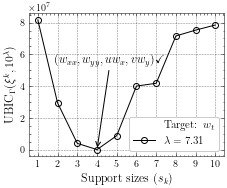

In [21]:
complexities = [len(efi) for efi in best_subsets]
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $w_t$')
    ax.plot(complexities, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(round(last_lam, 2))}$")
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('$(w_{xx}, w_{yy}, uw_{x}, vw_{y})\checkmark$', fontsize=12, 
                 xy=(complexities[best_bc], last_ubic[best_bc]), 
                 xytext=(complexities[best_bc]-2.125, last_ubic[1]+2.5e7), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=11)
#     fig.savefig("../Figures/NV/nv_scale_ubic.pdf")
    plt.show()
    plt.close()

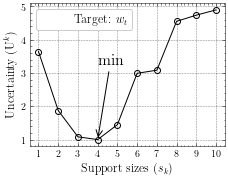

In [21]:
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $w_t$')
    ax.plot(complexities, b_uns, 'o-', c='black', markerfacecolor='none')
    ax.set_xticks(complexities)
    ax.set_ylabel("Uncertainty ($\\textrm{U}^{k}$)", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('min', fontsize=16, 
                 xy=(complexities[best_bc], b_uns[best_bc]), 
                 xytext=(complexities[best_bc], b_uns[best_bc]+2.25), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12)
    # fig.savefig("../Figures/NV/nv_uns.pdf")
    plt.show()
    plt.close()

In [22]:
ud_X, un_best_subsets, ud_y = h5file("./IPI_output_files/PMS_undenoised_full_data.h5", 'r')
_, ud_bics, _ = baye_uncertainties([np.where(e>0)[0].tolist() for e in un_best_subsets], 
                                   (ud_X, ud_y), u_type='cv1', take_sqrt=True)

['X_pre', 'best_subsets', 'y_pre']


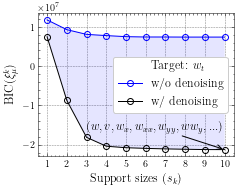

In [23]:
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $w_t$')
    ax.plot(complexities, ud_bics, 'o-', c='blue', markerfacecolor='none', label="w/o denoising")
    ax.plot(complexities, b_bics, 'o-', c='black', markerfacecolor='none', label="w/ denoising")
    ax.fill_between(complexities, ud_bics, b_bics, facecolor='blue', alpha=0.1)
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{BIC}(\\xi^{k}_{\\mu})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate(f"$({', '.join(np.array(inter_names)[list(best_subsets[np.argmin(b_bics)])][:6])+', ...'})$", fontsize=12, 
                 xy=(complexities[np.argmin(b_bics)], b_bics[np.argmin(b_bics)]), 
                 xytext=(complexities[np.argmin(b_bics)]-7, b_bics[np.argmin(b_bics)]+5e6), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=12)
#     fig.savefig("../Figures/NV/nv_bic.pdf")
    plt.show()
    plt.close()

In [24]:
# tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
# for i in range(len(best_subsets)):
#     tmp[i:i+1, :][0, best_subsets[i]] = 1.0
# best_subsets = tmp.astype(np.float32)
# # best_subsets

# pms_data = {"X_pre": X_pre, 
#             "y_pre": y_pre, 
#             "best_subsets": best_subsets}

# # pms_data
# h5file(file_path="./IPI_output_files/PMS_denoised_full_data.h5", cdict=pms_data, mode='w')